## Imports

In [197]:
import pandas as pd
import numpy as np
from datetime import datetime
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt


from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder


RANDOM_STATE = 666

## Functions and Classes

In [198]:
def feature_gen(X, reference_date='2018-01-01'):
    X = X.copy()
    if 'founded_at' in X.columns and 'closed_at' in X.columns:
        mask = X['closed_at'].notna()
        X.loc[mask, 'lifetime'] = (X.loc[mask, 'closed_at'] - X.loc[mask, 'founded_at']).dt.days
        X.loc[~mask, 'lifetime'] = (datetime.strptime(reference_date, '%Y-%m-%d') - X.loc[~mask, 'founded_at']).dt.days
    
    elif 'lifetime' in X.columns and 'founded_at' not in X.columns:
        X['founded_at'] = (datetime.strptime(reference_date, '%Y-%m-%d') - pd.to_timedelta(X['lifetime'], unit='d'))

    if 'closed_at' in X.columns:
        X = X.drop(columns=['closed_at'])

    X['days_to_first_funding'] = (X.first_funding_at - X.founded_at).dt.days
    X['days_to_last_funding'] = (X.last_funding_at - X.founded_at).dt.days
    X['days_between_first_last'] = (X.last_funding_at - X.first_funding_at).dt.days
    
    X['avg_days_between_funding'] = np.where(X['funding_rounds'] == 1, 0, X['days_between_first_last'] / (X['funding_rounds'] - 1))
    X['avg_funding_per_round'] = np.where(X['funding_rounds'] == 0, 0, X['funding_total_usd'] / X['funding_rounds'])

    X['first_funding_epoch'] = X['first_funding_at'].astype('int64') / 10**9
    X['last_funding_epoch'] = X['last_funding_at'].astype('int64') / 10**9
    X['founded_epoch'] = X['founded_at'].astype('int64') / 10**9

    X= X.drop(columns=['first_funding_at', 'last_funding_at', 'founded_at'])

    mask = X['category_list'].notna()
    X.loc[mask, 'categories_count'] = X.loc[mask, 'category_list'].apply(lambda x: len(x.split('|')))
    X.loc[~mask, 'categories_count'] = 0

    X['lf_ratio'] = X['days_to_first_funding'] / X['lifetime']

    X['funding_total_usd_log'] = np.log1p(X['funding_total_usd'])

    def get_sentiment(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

    X['name_sentiment'] = X['name'].iloc[:, ].apply(get_sentiment)

    return X


def na_funding_influence(data):
    print(f'Количество стартапов и их раундов финансирования с отсутствующей суммой:{data[data.funding_total_usd.isna()][["funding_rounds"]].value_counts()}')
    print(f'\nРаспределение целевой переменной для этой категории:{data[data.funding_total_usd.isna()][["status"]].value_counts()}\n')
    print(f'Процент отсутствующих данных по финансированию от всех: {data.funding_total_usd.isna().sum() * 100 / data.shape[0]:.2f}%')
    print(f'Процент закрывшихся стартапов для этой категории относительно общего числа закрытых: {data[data.funding_total_usd.isna() & data.status.isin(["closed"])].shape[0] * 100 / data.status.isin(["closed"]).sum():.2f}%')

def correct_dates(data):
    median_diff = (data.loc[data['founded_at'] <= data['first_funding_at'], 'first_funding_at'] - data.loc[data['founded_at'] <= data['first_funding_at'], 'founded_at']).median()
    # Корректировка данных с ошибкой в дате
    data.loc[data['founded_at'] > data['first_funding_at'], 'founded_at'] = data.loc[data['founded_at'] > data['first_funding_at'], 'first_funding_at'] - median_diff
    # Проверка корректировки
    print('Стартапы с ошибками в датах относительно founded_at после корректировки:')
    print(data[(data['founded_at'] > data['first_funding_at']) | (data['founded_at'] > data['last_funding_at'])].shape[0])
    return data


## Data read

In [199]:
data = pd.read_csv('datasets/kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
test = pd.read_csv('datasets/kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'])

In [200]:
data.info()
display(data.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

name               category_list  funding_total_usd  \
39107    InstallTracker  Analytics|Mobile Analytics          1000000.0   
34714  Search and Share                         NaN                NaN   
21622     Parkplatzking       Public Transportation                NaN   

          status country_code state_code  region    city  funding_rounds  \
39107  operating          GBR         H9  London  London               1   
34714     closed          NaN        NaN     NaN     NaN               1   
21622  operating          NaN        NaN     NaN     NaN               1   

      founded_at first_funding_at last_funding_at  closed_at  
39107 2015-01-30       2015-03-26      2015-03-26        NaT  
34714 2014-02-13       2015-09-15      2015-09-15 2016-10-30  
21622 2012-10-15       2012-10-15      2012-10-15        NaT

In [201]:
test.info()
display(test.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


name                category_list  funding_total_usd country_code  \
5927   BiocroÃ­             Clean Technology          1182192.0          NaN   
4315  hellocasa       Home & Garden|Services           537817.0          NaN   
1127    Recomio  Reviews and Recommendations                NaN          NaN   

     state_code region city  funding_rounds first_funding_at last_funding_at  \
5927        NaN    NaN  NaN               1       2011-10-07      2011-10-07   
4315        NaN    NaN  NaN               1       2015-04-09      2015-04-09   
1127        NaN    NaN  NaN               1       2012-11-21      2012-11-21   

      lifetime  
5927      2583  
4315       637  
1127      2402

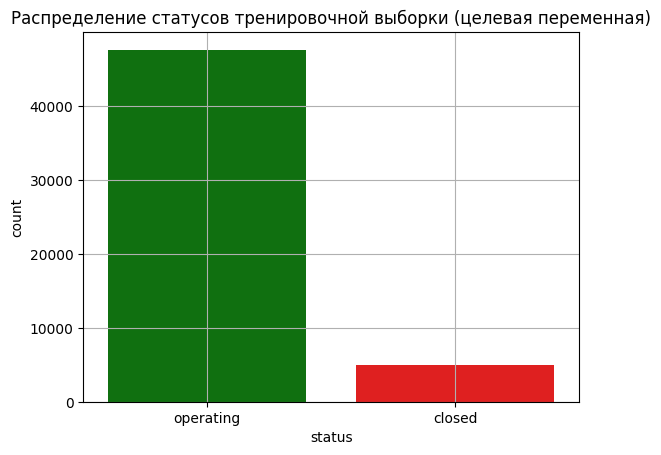

In [202]:
ax = sns.countplot(data=data, x='status', hue='status', palette={'operating': 'green', 'closed': 'red'})
ax.set_title('Распределение статусов тренировочной выборки (целевая переменная)')
ax.grid(True)
plt.show()

## Initial data assessment

In [203]:
print(f'Пропуски в представленных данных:\n{data.isna().sum()}')

Пропуски в представленных данных:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


In [204]:
print('Строка с отсутствующим именем стартапа:')
display(data[data["name"].isna()])

Строка с отсутствующим именем стартапа:


name category_list  funding_total_usd  status country_code state_code  \
3291  NaN      Startups            25000.0  closed          USA         OR   

                region      city  funding_rounds founded_at first_funding_at  \
3291  Portland, Oregon  Portland               1 2011-10-01       2012-03-01   

     last_funding_at  closed_at  
3291      2012-03-01 2013-06-03

In [205]:
print('Уникальных значений признаков в тренировочных данных:')
data.nunique()

Уникальных значений признаков в тренировочных данных:


name                 52515
category_list        22105
funding_total_usd    15551
status                   2
country_code           134
state_code             300
region                1036
city                  4477
funding_rounds          19
founded_at            5402
first_funding_at      4603
last_funding_at       4305
closed_at             3008
dtype: int64

In [206]:
print('Пример категорий стартапов:')
display(data.category_list.sample(10))

Пример категорий стартапов:


37665                                          Web Hosting
40355                                          Advertising
20535                             Business Services|Mobile
43638                                                  NaN
5323     Analytics|Mobile Advertising|Mobile Analytics|...
41155    Advertising|Advertising Networks|Advertising P...
31737                           Entertainment|Media|Sports
6983                                                   NaN
32641                                  Entertainment|Games
47551    E-Commerce|Mobile|Shopping|Transaction Processing
Name: category_list, dtype: object

In [207]:
print('Меры центральной тенденции признака funding_total_usd:')
data.funding_total_usd.describe()

Меры центральной тенденции признака funding_total_usd:


count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

In [208]:
na_funding_influence(data)

Количество стартапов и их раундов финансирования с отсутствующей суммой:funding_rounds
1                 9189
2                  706
3                  121
4                   36
5                    8
6                    3
7                    2
10                   2
8                    1
9                    1
Name: count, dtype: int64

Распределение целевой переменной для этой категории:status   
operating    9044
closed       1025
Name: count, dtype: int64

Процент отсутствующих данных по финансированию от всех: 19.17%
Процент закрывшихся стартапов для этой категории относительно общего числа закрытых: 20.85%


In [209]:
for col in data.select_dtypes(include='datetime64[ns]').columns:
    print(f'{col}: минимальное значение даты {data[col].min()} - максимальное значение даты {data[col].max()}')

founded_at: минимальное значение даты 1970-02-05 00:00:00 - максимальное значение даты 2016-04-02 00:00:00
first_funding_at: минимальное значение даты 1977-05-15 00:00:00 - максимальное значение даты 2015-12-05 00:00:00
last_funding_at: минимальное значение даты 1977-05-15 00:00:00 - максимальное значение даты 2015-12-07 00:00:00
closed_at: минимальное значение даты 1983-10-06 00:00:00 - максимальное значение даты 2017-10-21 00:00:00


## Errors and NA

In [210]:
print('Стартапы с ошибками в датах относительно founded_at (Дата основания больше даты первого или последнего финансирования):')
print('Строк, учитывая last_funding_at:',data[(data['founded_at'] > data['first_funding_at']) | (data['founded_at'] > data['last_funding_at'])].shape[0], '\n')
data[(data['founded_at'] > data['first_funding_at'])].info()
print('\nСтартапы с ошибками в датах относительно first_funding_at:')
print('Всего строк:',data[(data['first_funding_at'] > data['last_funding_at'])].shape[0])

Стартапы с ошибками в датах относительно founded_at (Дата основания больше даты первого или последнего финансирования):
Строк, учитывая last_funding_at: 2935 

<class 'pandas.core.frame.DataFrame'>
Index: 2935 entries, 34 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               2935 non-null   object        
 1   category_list      2847 non-null   object        
 2   funding_total_usd  2294 non-null   float64       
 3   status             2935 non-null   object        
 4   country_code       2642 non-null   object        
 5   state_code         2575 non-null   object        
 6   region             2618 non-null   object        
 7   city               2618 non-null   object        
 8   funding_rounds     2935 non-null   int64         
 9   founded_at         2935 non-null   datetime64[ns]
 10  first_funding_at   2935 non-null   datetime64[ns]
 11  last_funding_at 

In [211]:
data = correct_dates(data)

Стартапы с ошибками в датах относительно founded_at после корректировки:
0


In [212]:
print(f'Стартапы, у которых более 3 пропущенных значений: {len(data[data.isna().sum(axis=1) > 3])}')
print(data[data.isna().sum(axis=1) > 3][['status']].value_counts())

Стартапы, у которых более 3 пропущенных значений: 6130


status   
operating    4828
closed       1302
Name: count, dtype: int64


In [213]:
print('Процент закрытых от общего числа закрытых стартапов с большим количеством пропусков:')
print(f'{(data[data.isna().sum(axis=1) > 3][["status"]].value_counts()/data[["status"]].value_counts()).iloc[1]*100:.2f}%')

Процент закрытых от общего числа закрытых стартапов с большим количеством пропусков:
26.48%


In [214]:
data['high_na'] = (data.isna().sum(axis=1) > 3).astype(int)

## Filled data analisys

In [215]:
na_funding_influence(data[data.high_na == 0])

Количество стартапов и их раундов финансирования с отсутствующей суммой:funding_rounds
1                 7313
2                  594
3                  101
4                   31
5                    6
6                    2
7                    2
10                   2
8                    1
9                    1
Name: count, dtype: int64



Распределение целевой переменной для этой категории:status   
operating    7470
closed        583
Name: count, dtype: int64

Процент отсутствующих данных по финансированию от всех: 17.36%
Процент закрывшихся стартапов для этой категории относительно общего числа закрытых: 16.13%


In [216]:
na_funding_influence(data[data.high_na == 1])

Количество стартапов и их раундов финансирования с отсутствующей суммой:funding_rounds
1                 1876
2                  112
3                   20
4                    5
5                    2
6                    1
Name: count, dtype: int64

Распределение целевой переменной для этой категории:status   
operating    1574
closed        442
Name: count, dtype: int64

Процент отсутствующих данных по финансированию от всех: 32.89%
Процент закрывшихся стартапов для этой категории относительно общего числа закрытых: 33.95%


### Data transformation

[ссылка на трансформаторы](#functions-and-classes)

In [217]:
txt_columns = data.select_dtypes(include='object').columns
num_columns = data.select_dtypes(include='number').columns

data[num_columns] = data.loc[:, num_columns].fillna(0)
data[txt_columns] = data.loc[:, txt_columns].fillna('None', axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  high_na            52516 non-null  int32         
dtypes: dat

In [218]:
cat_columns = ['funding_rounds', 'high_na']
num_columns = ['funding_rounds', 'funding_total_usd']
high_car_columns = ['category_list', 'country_code', 'state_code', 'region', 'city']

### Categorial

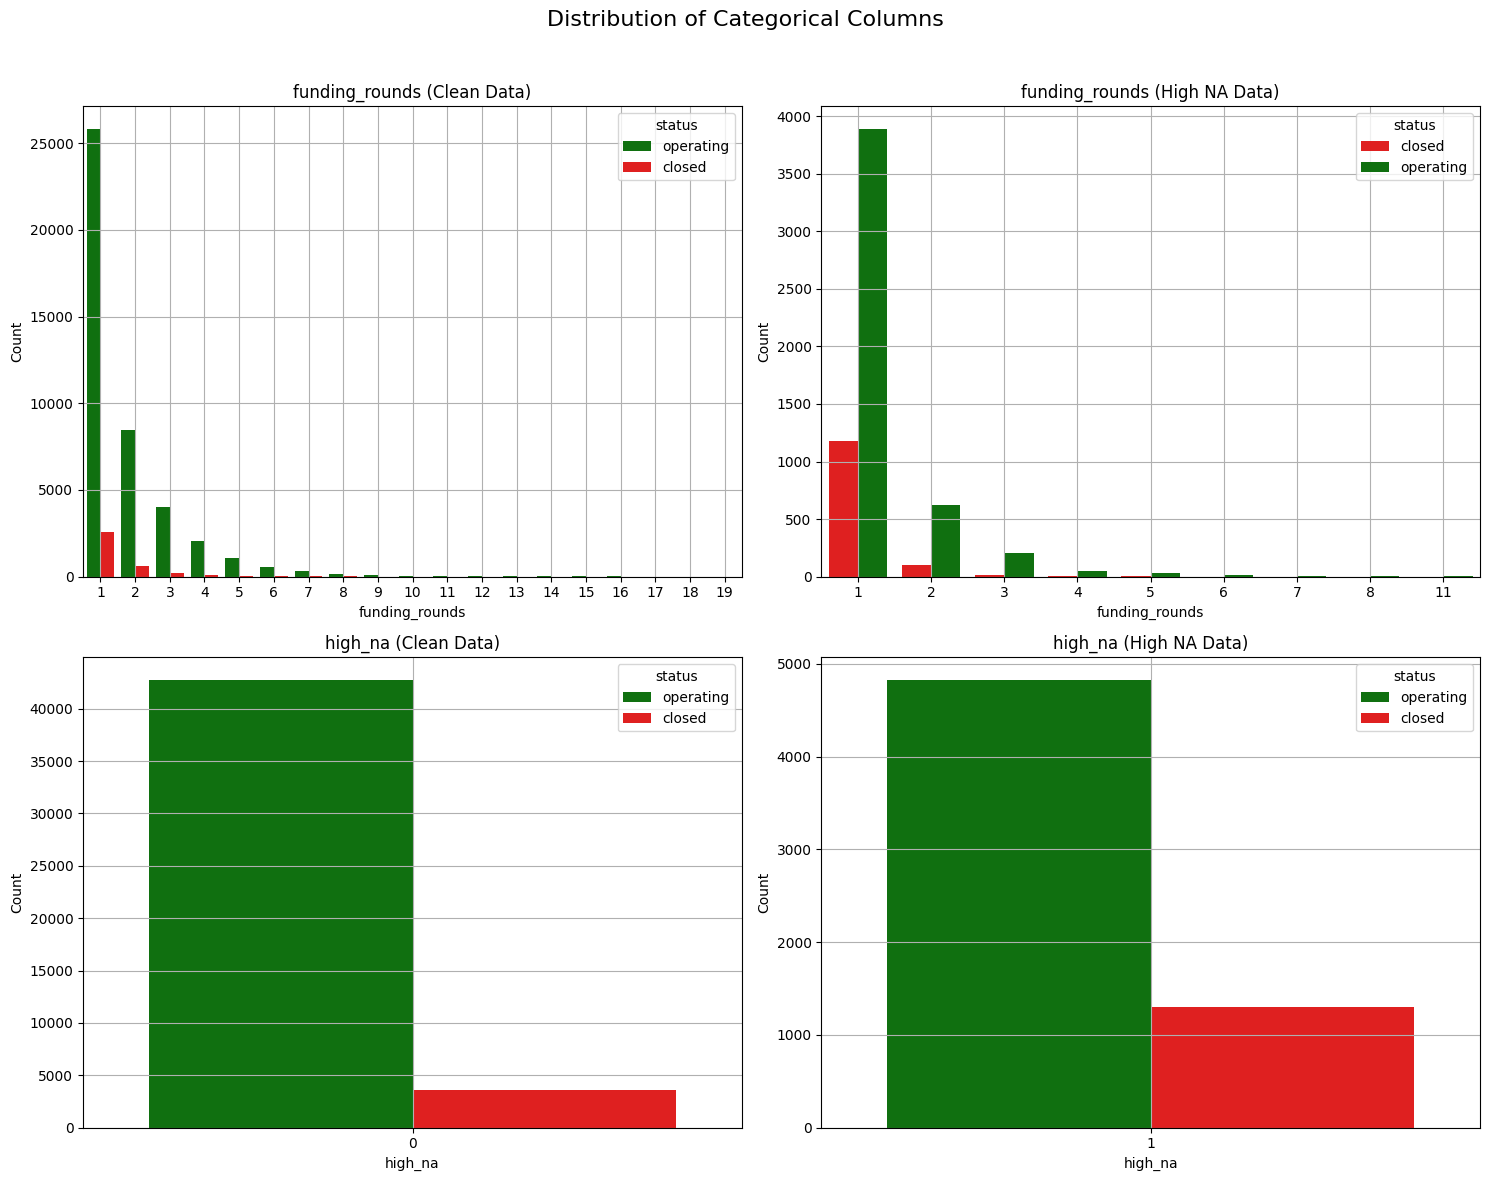

In [219]:
fig, axes = plt.subplots(nrows=len(cat_columns), ncols=2, figsize=(15, 6*len(cat_columns)))
fig.suptitle('Distribution of Categorical Columns', fontsize=16)

for i, col in enumerate(cat_columns):
    sns.countplot(data=data[data['high_na'] == 0], x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.countplot(data=data[data['high_na'] == 1], x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Numerical

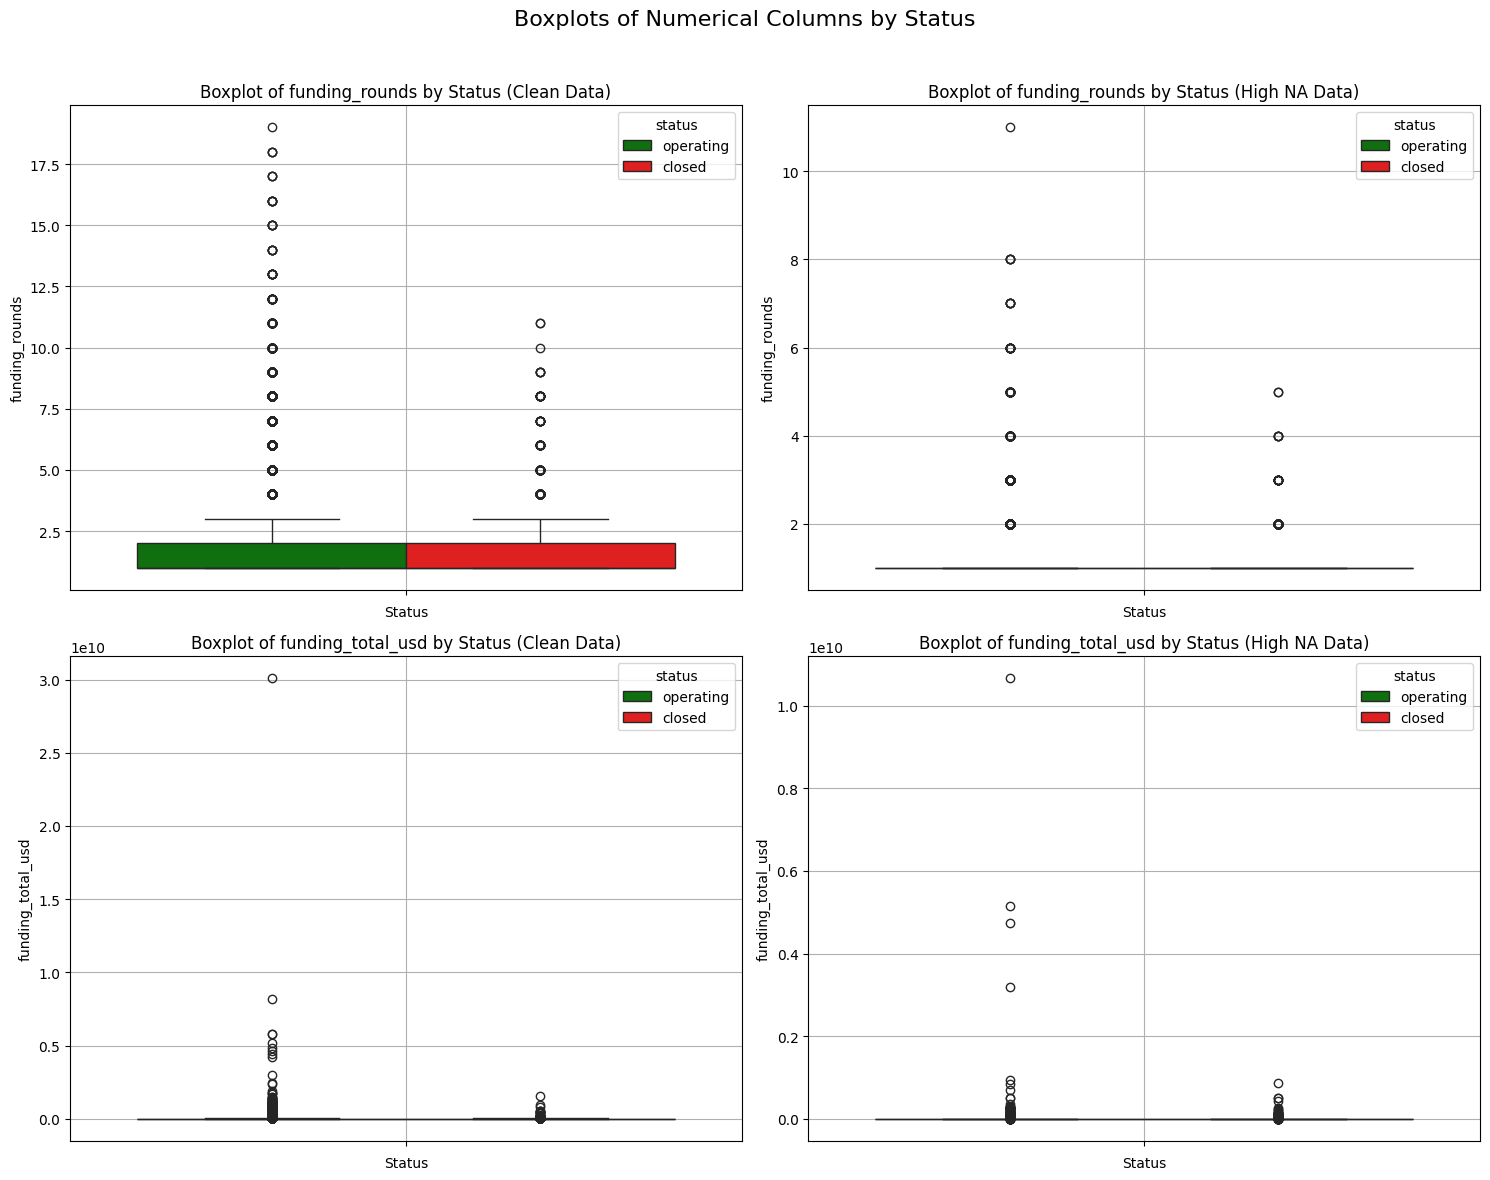

In [220]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6* len(num_columns)))
fig.suptitle('Boxplots of Numerical Columns by Status', fontsize=16)

for i, col in enumerate(num_columns):
    sns.boxplot(data=data[data['high_na'] == 0], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {col} by Status (Clean Data)')
    axes[i, 0].set_xlabel('Status')
    axes[i, 0].set_ylabel(col)
    axes[i, 0].grid(True)


    sns.boxplot(data=data[data['high_na'] == 1], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col} by Status (High NA Data)')
    axes[i, 1].set_xlabel('Status')
    axes[i, 1].set_ylabel(col)
    axes[i, 1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

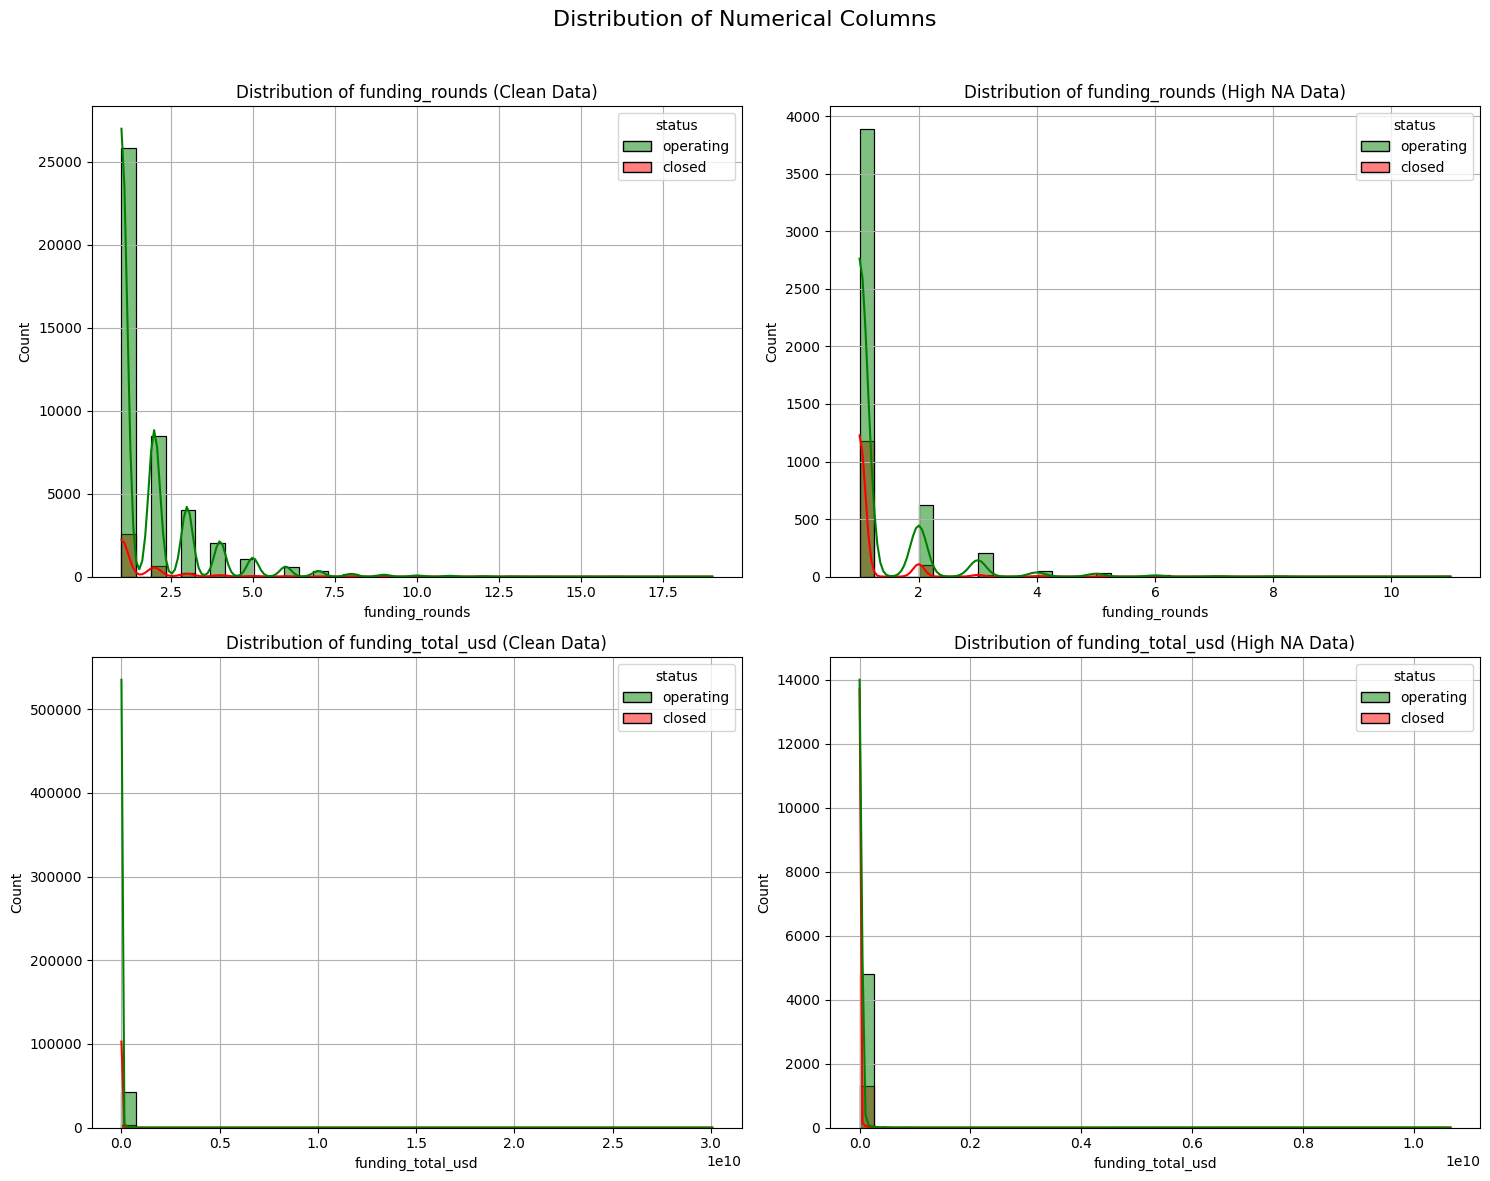

In [221]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6*len(num_columns)))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, col in enumerate(num_columns):
    sns.histplot(data=data[data['high_na'] == 0], x=col, hue='status', bins=40, ax=axes[i, 0], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 0].set_title(f'Distribution of {col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.histplot(data=data[data['high_na'] == 1], x=col, hue='status', bins=40, ax=axes[i, 1], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 1].set_title(f'Distribution of {col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

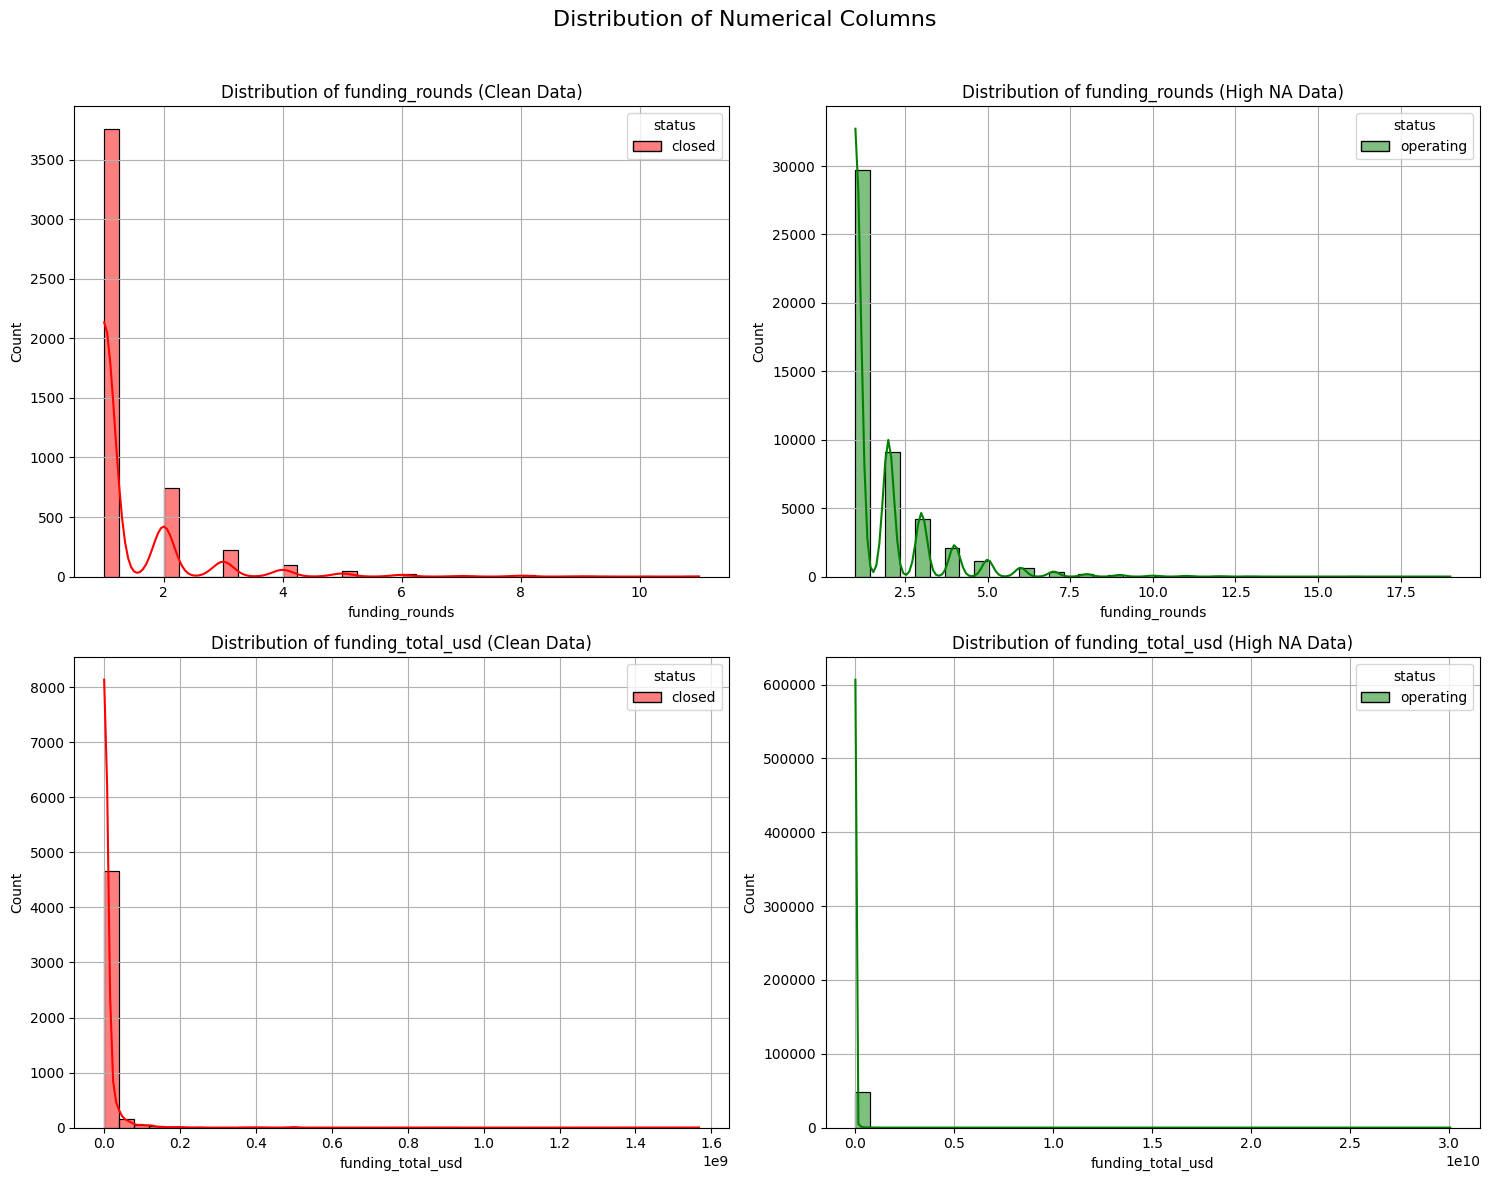

In [222]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6*len(num_columns)))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, col in enumerate(num_columns):
    sns.histplot(data=data[data['status'] == 'closed'], x=col, hue='status', bins=40, ax=axes[i, 0], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 0].set_title(f'Distribution of {col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.histplot(data=data[data['status'] == 'operating'], x=col, hue='status', bins=40, ax=axes[i, 1], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 1].set_title(f'Distribution of {col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### High Cardinality

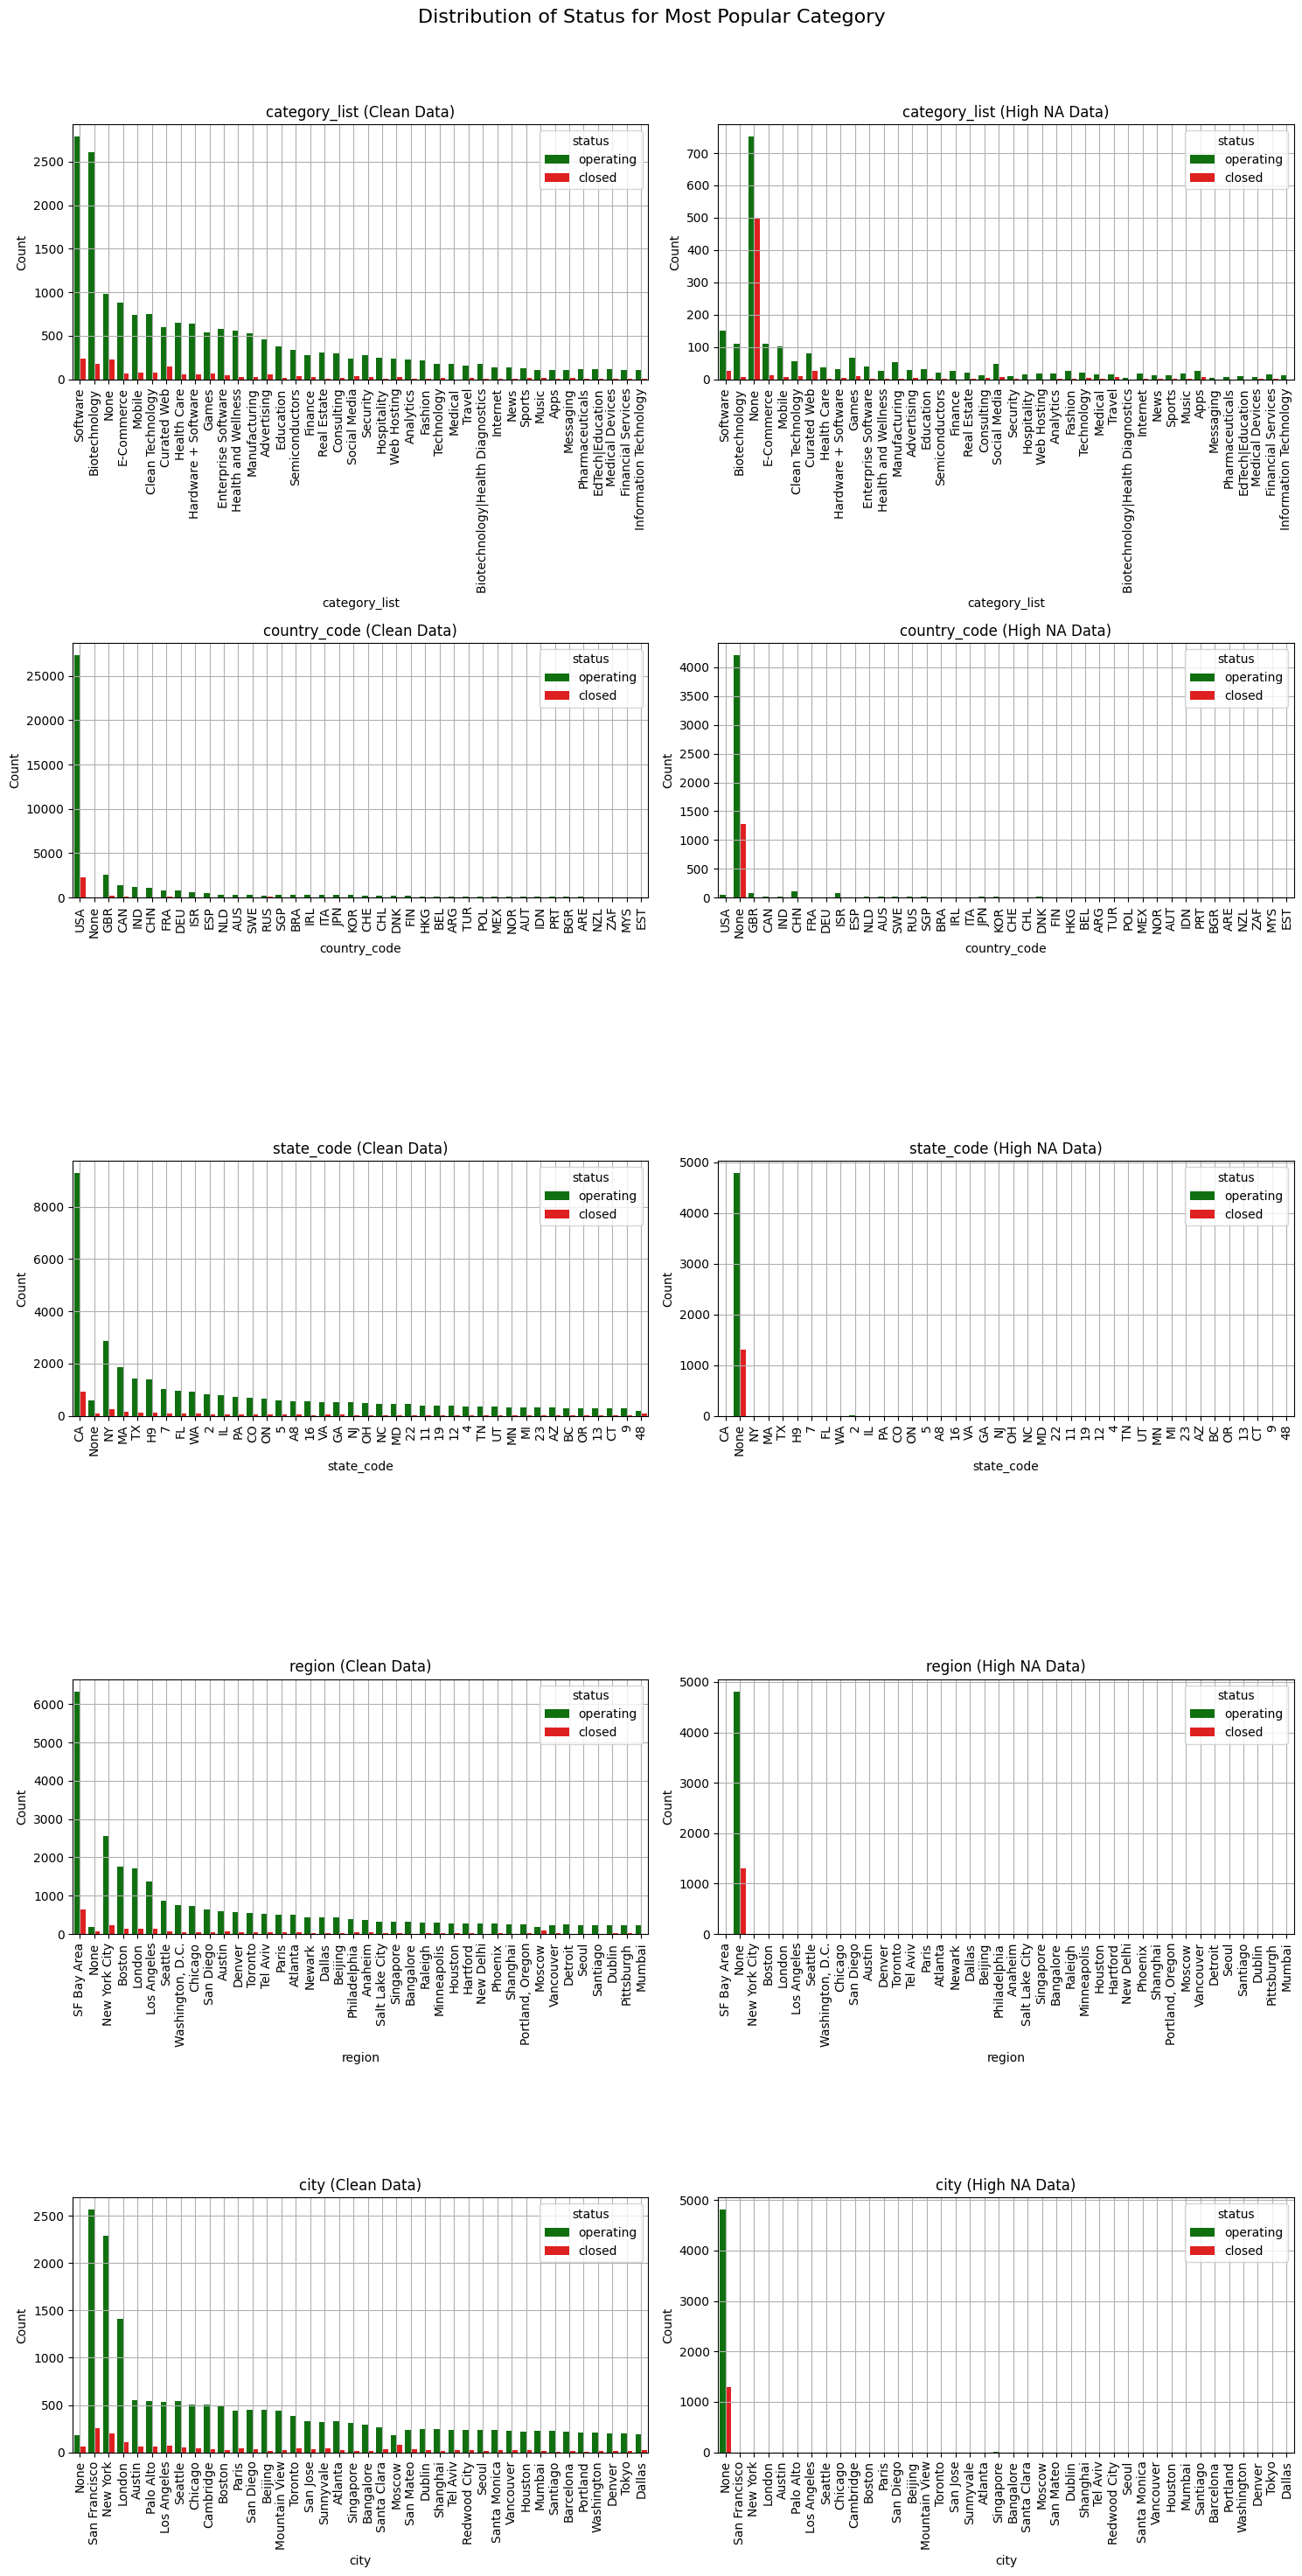

In [223]:
fig, axes = plt.subplots(nrows=len(high_car_columns), ncols=2, figsize=(15, 6*len(high_car_columns)))
fig.suptitle('Distribution of Status for Most Popular Category', fontsize=16)

for i, col in enumerate(high_car_columns):
    top_categories = data[col].value_counts().nlargest(40).index.tolist()
    filtered_data = data[data[col].isin(top_categories)]


    sns.countplot(data=filtered_data[filtered_data['high_na'] == 0], order=top_categories, x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)
    axes[i, 0].tick_params(axis='x', rotation=90)

    sns.countplot(data=filtered_data[filtered_data['high_na'] == 1], order=top_categories, x=col, hue='status', palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Feature generation

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
 13  high_na            52516 non-null  int32         
dtypes: dat

In [225]:
data = feature_gen(data)

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      52516 non-null  object 
 1   category_list             52516 non-null  object 
 2   funding_total_usd         52516 non-null  float64
 3   status                    52516 non-null  object 
 4   country_code              52516 non-null  object 
 5   state_code                52516 non-null  object 
 6   region                    52516 non-null  object 
 7   city                      52516 non-null  object 
 8   funding_rounds            52516 non-null  int64  
 9   high_na                   52516 non-null  int32  
 10  lifetime                  52516 non-null  float64
 11  days_to_first_funding     52516 non-null  int64  
 12  days_to_last_funding      52516 non-null  int64  
 13  days_between_first_last   52516 non-null  int64  
 14  avg_da

## High cardinality values transformation

In [227]:
def handle_high_car(data):
    data['category_list'] = data['category_list'].apply(lambda x: x.split('|'))
    sentences = data['category_list'].tolist()

    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    def get_category_vector(categories, model):
        vectors = [model.wv[cat] for cat in categories if cat in model.wv]
        if len(vectors) > 0:
            return np.mean(vectors, axis=0)  # Усреднение векторов
        else:
            return np.zeros(model.vector_size)  # Возвращаем нулевой вектор, если категорий нет в модели

    # Применяем функцию к каждому списку категорий
    data['category_vector'] = data['category_list'].apply(lambda x: get_category_vector(x, model))

    # Применяем Target Encodingv

    # Преобразуем список векторов в отдельные столбцы
    category_vectors = pd.DataFrame(data['category_vector'].tolist(), index=data.index)
    category_vectors.columns = [f'category_vec_{i}' for i in range(category_vectors.shape[1])]

    # Объединяем все признаки
    data = pd.concat([data.drop(columns=['category_vector']), category_vectors], axis=1)
    data = data.drop(columns=['category_list'])
    data.info()
    return data, category_vectors.columns

In [228]:
target_encoder = TargetEncoder()

target_encoder.fit(data[['country_code', 'state_code', 'region', 'city', 'category_list']], data['status'])

data[['country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded', 'category_list_encoded']] = target_encoder.transform(data[['country_code', 'state_code', 'region', 'city', 'category_list']])
data = data.drop(columns=['country_code', 'state_code', 'region', 'city', 'name'])

data[['country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded']]

country_encoded  state_code_encoded  region_encoded  city_encoded
0             0.912193            0.936841        0.933847      0.933948
1             0.923102            0.908406        0.908465      0.914035
2             0.923102            0.908406        0.908465      0.913630
3             0.766321            0.793911        0.785067      0.785067
4             0.923102            0.929401        0.964728      0.934346
...                ...                 ...             ...           ...
52511         0.916877            0.923697        0.917073      0.960629
52512         0.958445            0.924409        0.955523      0.955523
52513         0.923102            0.908406        0.908465      0.908285
52514         0.923102            0.908406        0.908465      0.913630
52515         0.925839            0.949597        0.958691      0.965120

[52516 rows x 4 columns]

In [229]:
data, vector_columns = handle_high_car(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Columns: 122 entries, funding_total_usd to category_vec_99
dtypes: float32(100), float64(16), int32(1), int64(4), object(1)
memory usage: 28.6+ MB


In [230]:
# from gensim.models import Word2Vec


# # Создание списка предложений для обучения модели Word2Vec
# sentences = data[high_car_columns].apply(lambda x: x.astype(str).tolist(), axis=1).tolist()

# # Обучение модели Word2Vec
# model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, seed=RANDOM_STATE)

# # Функция для преобразования строки в вектор
# def vectorize_column(column):
#     return column.apply(lambda x: model.wv[x] if x in model.wv else np.zeros(100))


# vec_columns = []
# # Преобразование столбцов в векторы
# for col in high_car_columns:
#     vectors = vectorize_column(data[col].astype(str))
#     vector_df = pd.DataFrame(vectors.tolist(), columns=[f'{col}_vec_{i}' for i in range(100)])
#     data = pd.concat([data, vector_df], axis=1)
#     vec_columns.extend([f'{col}_vec_{i}' for i in range(100)])

# # Удаление исходных столбцов с высокой кардинальностью
# data.drop(columns=high_car_columns, inplace=True)

# data.info()

In [231]:
# from sklearn.preprocessing import MultiLabelBinarizer

# # Частотное кодирование
# def frequency_encoding(df, column):
#     freq_encoding = df[column].value_counts().to_dict()
#     df[column + '_freq'] = df[column].map(freq_encoding)
#     return df

# for col in high_car_columns:
#     data = frequency_encoding(data, col)

# # Бинаризация категорий
# mlb = MultiLabelBinarizer()
# category_list_encoded = mlb.fit_transform(data['category_list'].apply(lambda x: x.split('|')))
# category_list_df = pd.DataFrame(category_list_encoded, columns=mlb.classes_)

# # Объединение бинаризованных категорий с исходным датафреймом
# data = pd.concat([data, category_list_df], axis=1)

# for col in high_car_columns:
#     data.drop(columns=[col], inplace=True)


## New features analysis

In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Columns: 122 entries, funding_total_usd to category_vec_99
dtypes: float32(100), float64(16), int32(1), int64(4), object(1)
memory usage: 28.6+ MB


In [235]:
num_columns = ['lifetime', 'days_to_first_funding', 'days_to_last_funding',
               'days_between_first_last', 'avg_days_between_funding', 'avg_funding_per_round',
               'first_funding_epoch', 'last_funding_epoch', 'founded_epoch',
               'lf_ratio', 'funding_total_usd_log', 'name_sentiment',
               'country_encoded', 'state_code_encoded', 'region_encoded',
               'city_encoded']
cat_columns = ['funding_rounds', 'categories_count']

### Numerical

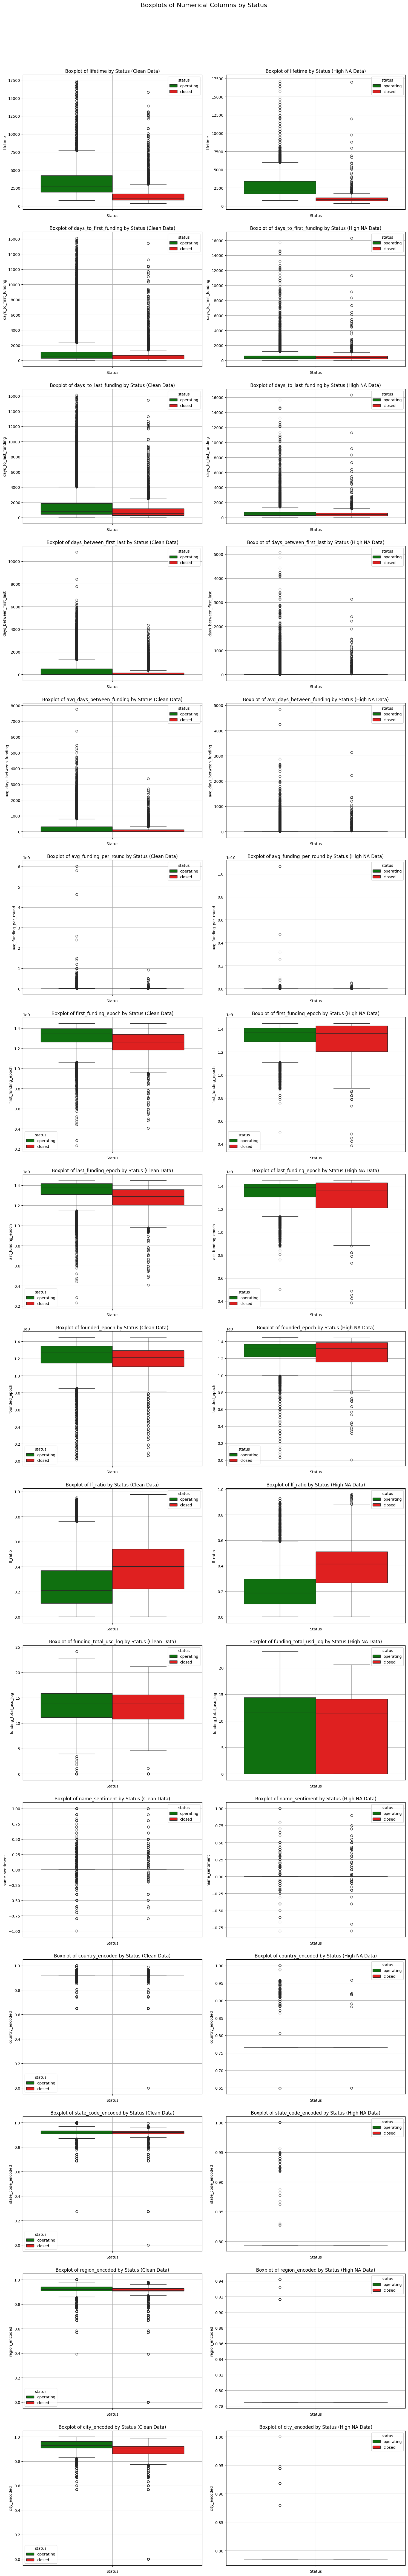

In [236]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6* len(num_columns)))
fig.suptitle('Boxplots of Numerical Columns by Status', fontsize=16)

for i, col in enumerate(num_columns):
    sns.boxplot(data=data[data['high_na'] == 0], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {col} by Status (Clean Data)')
    axes[i, 0].set_xlabel('Status')
    axes[i, 0].set_ylabel(col)
    axes[i, 0].grid(True)


    sns.boxplot(data=data[data['high_na'] == 1], hue='status', y=col, palette={'operating': 'green', 'closed': 'red'}, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col} by Status (High NA Data)')
    axes[i, 1].set_xlabel('Status')
    axes[i, 1].set_ylabel(col)
    axes[i, 1].grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

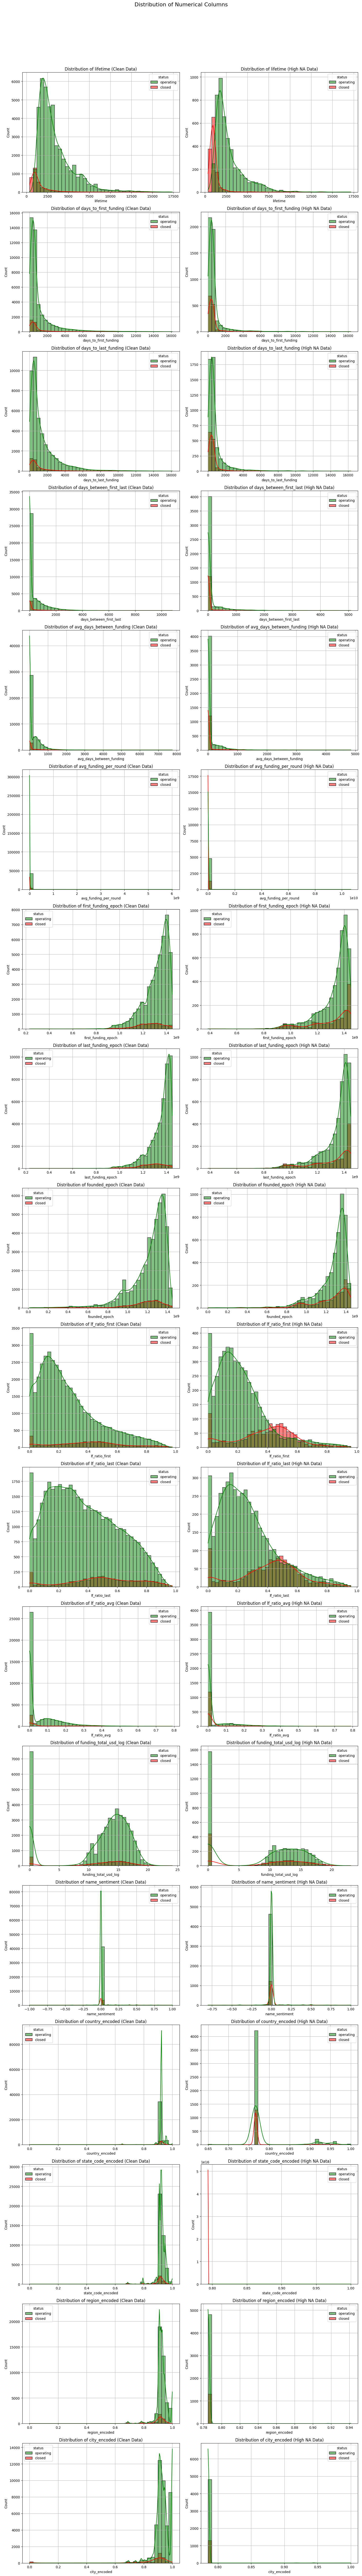

In [151]:
fig, axes = plt.subplots(nrows=len(num_columns), ncols=2, figsize=(15, 6*len(num_columns)))
fig.suptitle('Distribution of Numerical Columns', fontsize=16)

for i, col in enumerate(num_columns):
    sns.histplot(data=data[data['high_na'] == 0], x=col, hue='status', bins=40, ax=axes[i, 0], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 0].set_title(f'Distribution of {col} (Clean Data)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].grid(True)

    sns.histplot(data=data[data['high_na'] == 1], x=col, hue='status', bins=40, ax=axes[i, 1], palette={'operating': 'green', 'closed': 'red'}, kde=True)
    axes[i, 1].set_title(f'Distribution of {col} (High NA Data)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [152]:
data['high_lf_ratio'] = (data['lf_ratio_first'] > 0.4).astype(int)
data['had_one_round'] = (data['funding_rounds'] == 1).astype(int)
data['low_funding'] = (data['funding_total_usd_log'] < 5).astype(int)
data['low_lt'] = (data['lifetime'] < 1250).astype(int)

In [153]:
data['status'] = data['status'].map({'operating': 0, 'closed': 1})

## Сorrelation

In [154]:
import phik

phik_matrix = data.drop(columns=vector_columns).phik_matrix()
# phik_matrix = data.phik_matrix()

interval columns not set, guessing: ['funding_total_usd', 'status', 'funding_rounds', 'high_na', 'lifetime', 'days_to_first_funding', 'days_to_last_funding', 'days_between_first_last', 'avg_days_between_funding', 'avg_funding_per_round', 'first_funding_epoch', 'last_funding_epoch', 'founded_epoch', 'categories_count', 'lf_ratio_first', 'lf_ratio_last', 'lf_ratio_avg', 'funding_total_usd_log', 'name_sentiment', 'country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded', 'category_list_encoded', 'high_lf_ratio', 'had_one_round', 'low_funding', 'low_lt']


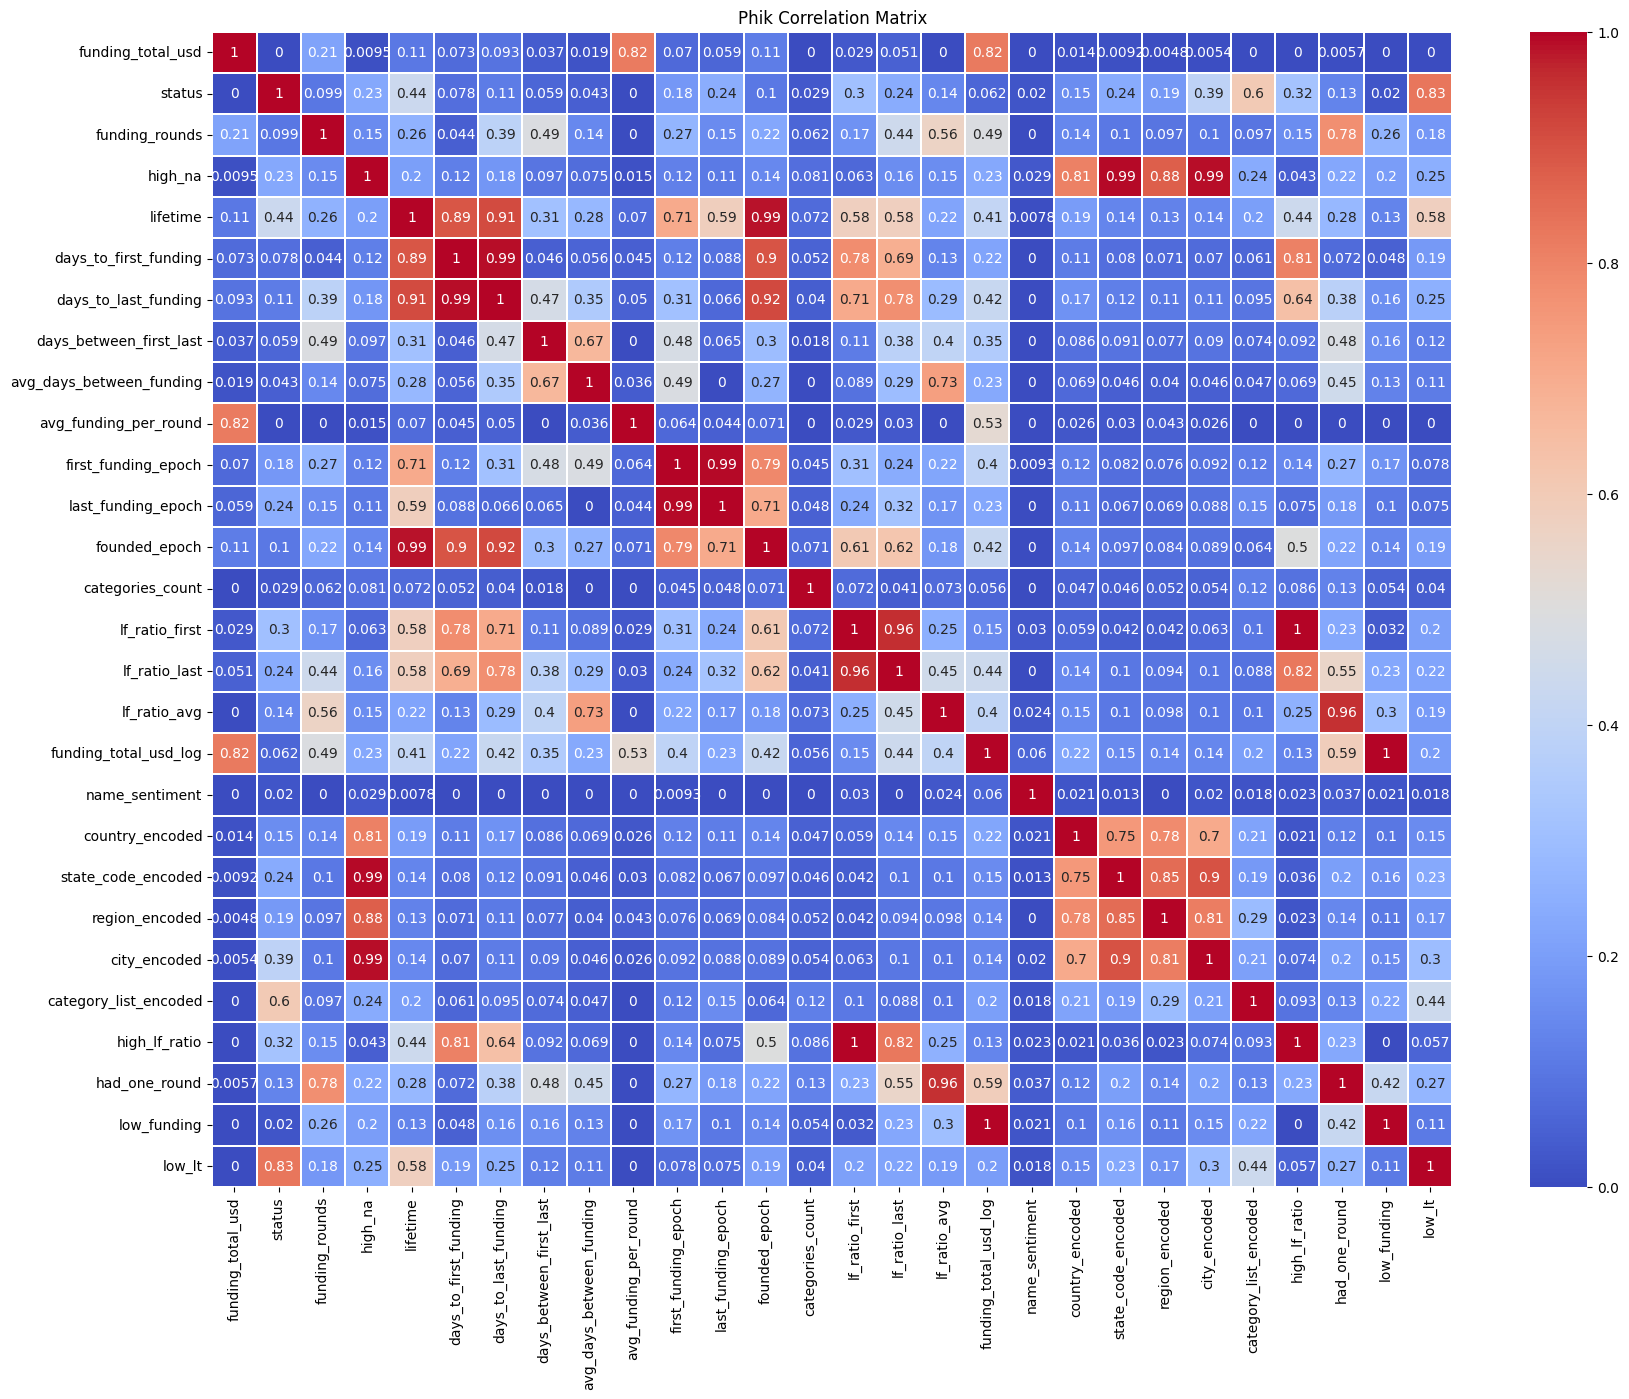

In [155]:
plt.figure(figsize=(20, 15))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, linewidths=0.1)
plt.title('Phik Correlation Matrix')
plt.show()

## Feature selection

In [156]:
threshold = 0.8

# Создаем маску для значений PhiK > 0.8 по модулю
high_phik_mask = (phik_matrix.abs() > threshold) & (phik_matrix != 1.0)
high_phik_features = phik_matrix[high_phik_mask].stack().reset_index()
high_phik_features.columns = ['Feature 1', 'Feature 2', 'PhiK']
high_phik_features['Feature 1'], high_phik_features['Feature 2'] = zip(
    *high_phik_features.apply(lambda row: sorted([row['Feature 1'], row['Feature 2']]), axis=1)
)
high_phik_features = high_phik_features.drop_duplicates()
print(high_phik_features)


                Feature 1              Feature 2      PhiK
0   avg_funding_per_round      funding_total_usd  0.819290
1       funding_total_usd  funding_total_usd_log  0.822538
2                  low_lt                 status  0.829004
3         country_encoded                high_na  0.806723
4                 high_na     state_code_encoded  0.994183
5                 high_na         region_encoded  0.877019
6            city_encoded                high_na  0.990936
7   days_to_first_funding               lifetime  0.894247
8    days_to_last_funding               lifetime  0.910526
9           founded_epoch               lifetime  0.986658
11  days_to_first_funding   days_to_last_funding  0.989795
12  days_to_first_funding          founded_epoch  0.896446
13  days_to_first_funding          high_lf_ratio  0.808061
16   days_to_last_funding          founded_epoch  0.915490
18    first_funding_epoch     last_funding_epoch  0.994723
23         lf_ratio_first          lf_ratio_last  0.9574

In [192]:
# features_to_drop = ['avg_funding_per_round', 'funding_total_usd', 'founded_epoch', 'first_funding_epoch', 'last_funding_epoch', 'lifetime', 'lf_ratio', 'name_sentiment', 'funding_rounds']
features_to_drop = ['lifetime', 'lf_ratio_first', 'lf_ratio_last', 'lf_ratio_avg', 'founded_epoch', 'avg_funding_per_round', 'funding_total_usd', 'city_encoded', 'first_funding_epoch',
                    'days_to_last_funding', 'last_funding_epoch', 'state_code_encoded', 'category_list_encoded', 'region_encoded', 'days_to_first_funding']
features_to_drop = []
first_set = data.drop(columns=features_to_drop)
first_set = first_set.drop(columns=vector_columns)
first_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   funding_total_usd         52516 non-null  float64
 1   status                    52516 non-null  int64  
 2   funding_rounds            52516 non-null  int64  
 3   high_na                   52516 non-null  int32  
 4   lifetime                  52516 non-null  float64
 5   days_to_first_funding     52516 non-null  int64  
 6   days_to_last_funding      52516 non-null  int64  
 7   days_between_first_last   52516 non-null  int64  
 8   avg_days_between_funding  52516 non-null  float64
 9   avg_funding_per_round     52516 non-null  float64
 10  first_funding_epoch       52516 non-null  float64
 11  last_funding_epoch        52516 non-null  float64
 12  founded_epoch             52516 non-null  float64
 13  categories_count          52516 non-null  float64
 14  lf_rat

In [193]:
first_set.head(10)

funding_total_usd  status  funding_rounds  high_na  lifetime  \
0           828626.0       0               2        0    2998.0   
1         42935019.0       0               4        0    4748.0   
2         35456381.0       0               3        0    4383.0   
3         22250000.0       0               3        1    5114.0   
4                0.0       0               1        0    2791.0   
5          4300000.0       0               1        0    2452.0   
6         90000000.0       0               1        0    6575.0   
7          4300000.0       0               1        0    4748.0   
8         42000000.0       0               2        0    5479.0   
9          1250500.0       0               2        0    2922.0   

   days_to_first_funding  days_to_last_funding  days_between_first_last  \
0                    561                  1871                     1310   
1                   1949                  3342                     1393   
2                   2423                  3104                      681   
3                   2800                  3851                     1051   
4                    630                   630                        0   
5                    576                   576                        0   
6                   5247                  5247                        0   
7                   3599                  3599                        0   
8                   1742                  3031                     1289   
9                    599                  1175                      576   

   avg_days_between_funding  avg_funding_per_round  ...  name_sentiment  \
0               1310.000000           4.143130e+05  ...             0.0   
1                464.333333           1.073375e+07  ...             0.0   
2                340.500000           1.181879e+07  ...             0.0   
3                525.500000           7.416667e+06  ...             0.0   
4                  0.000000           0.000000e+00  ...             0.0   
5                  0.000000           4.300000e+06  ...             0.0   
6                  0.000000           9.000000e+07  ...             0.0   
7                  0.000000           4.300000e+06  ...             0.0   
8               1289.000000           2.100000e+07  ...             0.0   
9                576.000000           6.252500e+05  ...             0.0   

   country_encoded  state_code_encoded  region_encoded  city_encoded  \
0         0.912193            0.936841        0.933847      0.933948   
1         0.923102            0.908406        0.908465      0.914035   
2         0.923102            0.908406        0.908465      0.913630   
3         0.766321            0.793911        0.785067      0.785067   
4         0.923102            0.929401        0.964728      0.934346   
5         0.923102            0.935677        0.932163      0.886889   
6         0.923102            0.908406        0.908465      0.914035   
7         0.923102            0.918047        0.914729      0.904965   
8         0.923102            0.908406        0.908465      0.884168   
9         0.923102            0.918047        0.901848      1.000000   

   category_list_encoded  high_lf_ratio  had_one_round  low_funding  low_lt  
0               1.000000              0              0            0       0  
1               0.900611              1              0            0       0  
2               0.935965              1              0            0       0  
3               0.917997              1              0            0       0  
4               0.955257              0              1            1       0  
5               0.909779              0              1            0       0  
6               1.000000              1              1            0       0  
7               0.916430              1              1            0       0  
8               0.935965              0              0            0       0  
9               0.895031              0 

In [194]:
high_phik_features[~high_phik_features['Feature 1'].isin(features_to_drop) & ~high_phik_features['Feature 2'].isin(features_to_drop)]

Feature 1              Feature 2      PhiK
0   avg_funding_per_round      funding_total_usd  0.819290
1       funding_total_usd  funding_total_usd_log  0.822538
2                  low_lt                 status  0.829004
3         country_encoded                high_na  0.806723
4                 high_na     state_code_encoded  0.994183
5                 high_na         region_encoded  0.877019
6            city_encoded                high_na  0.990936
7   days_to_first_funding               lifetime  0.894247
8    days_to_last_funding               lifetime  0.910526
9           founded_epoch               lifetime  0.986658
11  days_to_first_funding   days_to_last_funding  0.989795
12  days_to_first_funding          founded_epoch  0.896446
13  days_to_first_funding          high_lf_ratio  0.808061
16   days_to_last_funding          founded_epoch  0.915490
18    first_funding_epoch     last_funding_epoch  0.994723
23         lf_ratio_first          lf_ratio_last  0.957430
24          high_lf_ratio         lf_ratio_first  0.999352
26          high_lf_ratio          lf_ratio_last  0.824572
27          had_one_round           lf_ratio_avg  0.956673
31         region_encoded     state_code_encoded  0.849792
32           city_encoded     state_code_encoded  0.900834
35           city_encoded         region_encoded  0.813201

## Cross-validation pipelines

In [195]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data_1 = first_set.copy()

def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['DecisionTree', 'RandomForest', 'XGBoost'])
    
    if classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 2, 32)
        classifier_obj = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced')
        
    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 500)
        max_depth = trial.suggest_int('max_depth', 10, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 32)
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                                                 max_features='log2', min_samples_leaf=min_samples_leaf, class_weight='balanced')
        
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 5, 10)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 32)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        classifier_obj = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                                        learning_rate=learning_rate, use_label_encoder=False, eval_metric='logloss')
        
    # else:
    #     n_estimators = trial.suggest_int('n_estimators', 10, 200)
    #     max_depth = trial.suggest_int('max_depth', 2, 16)
    #     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    #     classifier_obj = CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose=0)
    
    pipeline = Pipeline([
        # ('scaler', StandardScaler()),
        ('classifier', classifier_obj)
    ])
    
    score = cross_val_score(pipeline, data_1.drop(columns=['status']), data_1['status'], n_jobs=-1, cv=5, scoring='f1')
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2025-02-04 17:40:45,766] A new study created in memory with name: no-name-76b3d4a3-7db6-48b7-a2fe-2cabd35b57b3
[I 2025-02-04 17:40:47,827] Trial 0 finished with value: 0.9908157775168667 and parameters: {'classifier': 'DecisionTree', 'max_depth': 26}. Best is trial 0 with value: 0.9908157775168667.
[I 2025-02-04 17:41:05,347] Trial 1 finished with value: 0.9479594105488476 and parameters: {'classifier': 'RandomForest', 'n_estimators': 481, 'max_depth': 19, 'min_samples_leaf': 2, 'max_leaf_nodes': 24}. Best is trial 0 with value: 0.9908157775168667.
[W 2025-02-04 17:41:14,052] Trial 2 failed with parameters: {'classifier': 'RandomForest', 'n_estimators': 402, 'max_depth': 17, 'min_samples_leaf': 2, 'max_leaf_nodes': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
              

KeyboardInterrupt: 

In [183]:
# Extract the best model from the study
best_params = study.best_trial.params
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model on the entire dataset
best_model.fit(data_1.drop(columns=['status']), data_1['status'])

# Get feature importances
importances = best_model.feature_importances_
features = data_1.drop(columns=['status']).columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances[feature_importances['Importance'] > 0]
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, len(feature_importances)//3))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances for the Best Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

KeyError: 'n_estimators'

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Разделение данных на тренировочную и валидационную выборки со стратификацией
X = data_1.drop(columns=['status'])
y = data_1['status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Обучение лучшей модели на тренировочных данных
best_model.fit(X_train, y_train)

# Предсказание на валидационной выборке
y_pred = best_model.predict(X_val)

# Вычисление F1-метрики для валидационной выборки
f1 = f1_score(y_val, y_pred)
print(f'F1-метрика для валидационной выборки: {f1:.4f}')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-метрика для валидационной выборки: 0.7625


## Test data prediction

In [168]:
test['high_na'] = (test.isna().sum(axis=1) > 3).astype(int)
test.info()
test_f = test.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  high_na            13125 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2), object(6)
memory usage: 1.2+ MB


In [169]:
# Преобразование тестовых данных
test_f = feature_gen(test_f)
txt_columns = test_f.select_dtypes(include='object').columns
num_columns = test_f.select_dtypes(include=['int64', 'float64', 'int32']).columns

# # Заполнение пропущенных значений
test_f[txt_columns] = test_f.loc[:, txt_columns].fillna('None', axis=1)
test_f[num_columns] = test_f.loc[:, num_columns].fillna(0, axis=1)

In [170]:
test_f, _ = handle_high_car(test_f)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Columns: 123 entries, name to category_vec_99
dtypes: float32(100), float64(18), object(5)
memory usage: 7.3+ MB


In [174]:
test_f[['country_encoded', 'state_code_encoded', 'region_encoded', 'city_encoded', 'category_list_encoded']] = target_encoder.transform(test[['country_code', 'state_code', 'region', 'city', 'category_list']])
test_f['high_lf_ratio'] = (test_f['lf_ratio_first'] > 0.4).astype(int)
test_f['low_lt'] = (test_f['lifetime'] < 1200).astype(int)
test_f['had_one_round'] = (test_f['funding_rounds'] == 1).astype(int)
test_f['low_funding'] = (test_f['funding_total_usd_log'] < 5).astype(int)

In [175]:
test_filled = test_f[data_1.columns.drop('status')]


test_filled.head(10)
# # Предсказание на тестовых данных

test_predictions = best_model.predict(test_filled)

# # Вывод первых 10 предсказаний
print(test_predictions[:10])
print(f'Количество стартапов, которые закроются: {test_predictions.sum()}')

[0 0 0 0 0 0 0 0 0 0]
Количество стартапов, которые закроются: 726


In [176]:
# Create a DataFrame with the names and predictions
predictions_df = pd.DataFrame({
    'name': test['name'],
    'status': np.where(test_predictions == 0, 'operating', 'closed')
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

# Display the first few rows of the DataFrame to verify
print(predictions_df.head())

                     name     status
0              Crystalsol  operating
1        JBI Fish & Wings  operating
2                COINPLUS  operating
3  Imagine Communications  operating
4                   DNA13  operating
